In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
def load_Compas_data(path):
    # Read the CSV file with the first row containing column names
    input_data = pd.read_csv('compas-scores-two-years.csv', sep=',', engine='python', header=0)

    # Filter the DataFrame to include only 'White' or 'Black' race
    input_data = input_data.loc[input_data['race'].isin(['African-American', 'Caucasian'])]

    sensitive_attribs = ['race', 'sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(race=lambda df: (df['race'] == 'Caucasian').astype(int),
                 sex=lambda df: (df['sex'] == 'Female').astype(int)))

    # targets;
    y = (input_data['two_year_recid'])

    # features; note that the 'target' and sentive attribute columns are dropped
    # Select specific columns using DataFrame.loc
    selected_columns = ["age_cat", "priors_count", "c_charge_degree"]
    X = input_data.loc[:, selected_columns].fillna('Unknown').pipe(pd.get_dummies, drop_first=True)

    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z

In [3]:
X, y, Z = load_Compas_data('compas-scores-two-years.csv')

n_features = X.shape[1]
n_sensitive = Z.shape[1]

# split into train/test set
(X_train, X_test, y_train, y_test,
 Z_train, Z_test) = train_test_split(X, y, Z, test_size=0.5,
                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                           columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 
print ("X",X_train)

features X: 6150 samples, 4 attributes
targets y: (6150,) samples
sensitives Z: 6150 samples, 2 attributes
X       priors_count  age_cat_Greater than 45  age_cat_Less than 25  \
99       -0.528464                -0.527309              1.911032   
4091     -0.528464                 1.896421             -0.523278   
5090      0.891837                 1.896421             -0.523278   
5422     -0.528464                -0.527309              1.911032   
3894     -0.325564                 1.896421             -0.523278   
...            ...                      ...                   ...   
341      -0.731364                -0.527309             -0.523278   
5925     -0.731364                -0.527309             -0.523278   
1869     -0.731364                -0.527309              1.911032   
3271      0.080236                -0.527309             -0.523278   
6240     -0.528464                -0.527309              1.911032   

      c_charge_degree_M  
99             1.382726  
4091      

In [4]:
class PandasDataSet(TensorDataset):

    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDataSet, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame('dummy')
        return torch.from_numpy(df.values).float()


train_data = PandasDataSet(X_train, y_train, Z_train)
test_data = PandasDataSet(X_test, y_test, Z_test)

In [5]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

print('# training samples:', len(train_data))
print('# batches:', len(train_loader))

# training samples: 3075
# batches: 96


In [6]:
class Classifier(nn.Module):

    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

In [7]:
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

In [8]:
def pretrain_classifier(clf, data_loader, optimizer, criterion):
    for x, y, _ in data_loader:
        clf.zero_grad()
        p_y = clf(x)
        loss = criterion(p_y, y)
        loss.backward()
        optimizer.step()
    return clf


N_CLF_EPOCHS = 2

for epoch in range(N_CLF_EPOCHS):
    clf = pretrain_classifier(clf, train_loader, clf_optimizer, clf_criterion)

In [9]:
class Adversary(nn.Module):

    def __init__(self, n_sensitive, n_hidden=32):
        super(Adversary, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_sensitive),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))


def pretrain_adversary(adv, clf, data_loader, optimizer, criterion):
    for x, _, z in data_loader:
        p_y = clf(x).detach()
        adv.zero_grad()
        p_z = adv(p_y)
        loss = (criterion(p_z, z) * lambdas).mean()
        loss.backward()
        optimizer.step()
    return adv


lambdas = torch.Tensor([130, 30])
adv = Adversary(Z_train.shape[1])
adv_criterion = nn.BCELoss(reduction='none')
adv_optimizer = optim.Adam(adv.parameters())


N_ADV_EPOCHS = 5

for epoch in range(N_ADV_EPOCHS):
    pretrain_adversary(adv, clf, train_loader, adv_optimizer, adv_criterion)

In [10]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



p_rulesForGender 89.75077410144921
p_rulesForRace 92.82675818366394
Accuracy 54.27642276422764



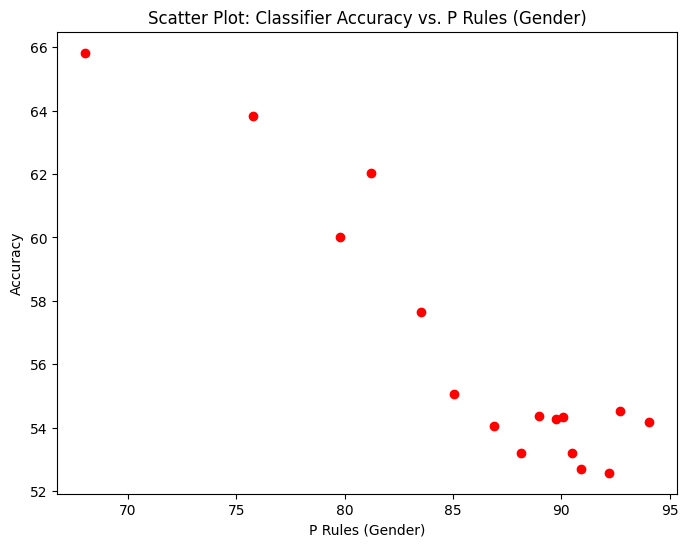

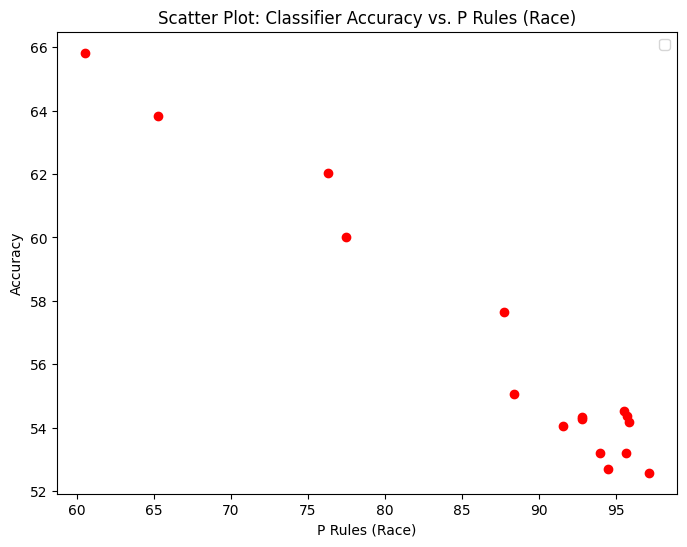

In [11]:

def train(clf, adv, data_loader, clf_criterion, adv_criterion,
          clf_optimizer, adv_optimizer, lambdas):
    
    # Train adversary
    for x, y, z in data_loader:
        p_y = clf(x)
        adv.zero_grad()
        p_z = adv(p_y)
        loss_adv = (adv_criterion(p_z, z) * lambdas).mean()
        loss_adv.backward()
        adv_optimizer.step()
 
    # Train classifier on single batch
    for x, y, z in data_loader:
        pass
    p_y = clf(x)
    p_z = adv(p_y)
    clf.zero_grad()
    p_z = adv(p_y)
    loss_adv = (adv_criterion(p_z, z) * lambdas).mean()
    clf_loss = clf_criterion(p_y, y) - (adv_criterion(adv(p_y), z) * lambdas).mean()
    clf_loss.backward()
    clf_optimizer.step()
    
    return clf, adv

clf_accuracy_list = []
p_rules_dict = {}  # Dictionary to store p-rules for attributes (sex and race)

N_EPOCH_COMBINED = 165

for epoch in range(1, N_EPOCH_COMBINED):
    
    clf, adv = train(clf, adv, train_loader, clf_criterion, adv_criterion,
                     clf_optimizer, adv_optimizer, lambdas)
    with torch.no_grad():
            clf_pred = clf(test_data.tensors[0])
            adv_pred = adv(clf_pred)
    y_post_clf = pd.Series(clf_pred.numpy().ravel(), index=y_test.index)
    Z_post_adv = pd.DataFrame(adv_pred.numpy(), columns=Z_test.columns)
    
    if epoch % 10 == 0:  # Only append values and create plots every 10 epochs
        clf_accuracy = metrics.accuracy_score(y_test, y_post_clf > 0.5) * 100
        # Calculate p-rules for both race and sex attributes
        p_rules = {
            'sex': p_rule(y_post_clf, Z_test['sex']),
            'race': p_rule(y_post_clf, Z_test['race'])
        }
        # Append values to lists
        clf_accuracy_list.append(clf_accuracy)
        p_rules_dict[epoch] = p_rules
        #print ('p_rules_dict',p_rules_dict)
        p_rulesFinalSex = p_rule(y_post_clf, Z_test['sex'])
        p_rulesFinalRace = p_rule(y_post_clf, Z_test['race'])
        clf_accuracyFinal = metrics.accuracy_score(y_test, y_post_clf > 0.5) * 100
    # Convert lists to arrays if needed
clf_accuracy_array = np.array(clf_accuracy_list)
print ()
print ('p_rulesForGender',p_rulesFinalSex)
print ('p_rulesForRace',p_rulesFinalRace)
print ('Accuracy',clf_accuracyFinal)
print ()
# Scatter plots for each attribute
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter([item['sex'] for item in p_rules_dict.values()], 
            clf_accuracy_array, 
             color='red', marker='o' )
# Add labels and title
plt.xlabel('P Rules (Gender)')
plt.ylabel('Accuracy')
plt.title('Scatter Plot: Classifier Accuracy vs. P Rules (Gender)')


# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter([item['race'] for item in p_rules_dict.values()], 
            clf_accuracy_array, 
             color='red', marker='o' )
# Add labels and title
plt.xlabel('P Rules (Race)')
plt.ylabel('Accuracy')
plt.title('Scatter Plot: Classifier Accuracy vs. P Rules (Race)') 
# Add legend
plt.legend()
    
# Show the plot
plt.show()